In [2]:
import subprocess
import numpy as np
import corner
import emcee
import ttvfast
%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime
import os

In [3]:
def to_eioo_coord(params):
    inner1 = np.sqrt(((params[4]*params[4])+(params[3]*params[3]))/4.)
    inner2 = np.sqrt(((params[4+7]*params[4+7])+(params[3+7]*params[3+7]))/4.)
    inner1, inner2 = np.clip(inner1, -1., 1.), np.clip(inner2, -1., 1.) 
    i1 = 2.*np.arcsin(inner1)*(180./np.pi)
    Ome1 = np.arctan2(params[4], params[3])*(180./np.pi)
    i2 = 2.*np.arcsin(inner2)*(180./np.pi)
    Ome2 = np.arctan2(params[4+7], params[3+7])*(180./np.pi)    
    params[3], params[4], params[3+7], params[4+7] = i1, Ome1, i2, Ome2
    
    e1 = np.sqrt(params[2]*params[2] + params[5]*params[5])
    ome1 = np.arctan2(params[5], params[2])*(180./np.pi) - Ome1
    e2 = np.sqrt(params[2+7]*params[2+7] + params[5+7]*params[5+7])
    ome2 = np.arctan2(params[5+7], params[2+7])*(180./np.pi) - Ome2
    params[2], params[5], params[2+7], params[5+7],  = e1, ome1, e2, ome2

    
def to_pal_coord(p1te, p2te):
    ix1 = 2*np.sin((np.pi/180.)*p1te[3]/2.)*np.cos(p1te[4]*(np.pi/180.))
    iy1 = 2*np.sin((np.pi/180.)*p1te[3]/2.)*np.sin(p1te[4]*(np.pi/180.))
    ix2 = 2*np.sin((np.pi/180.)*p2te[3]/2.)*np.cos(p2te[4]*(np.pi/180.))
    iy2 = 2*np.sin((np.pi/180.)*p2te[3]/2.)*np.sin(p2te[4]*(np.pi/180.))
    k1 = p1te[2] * np.cos(p1te[4]*(np.pi/180.) + p1te[5]*(np.pi/180.))
    h1 = p1te[2] * np.sin(p1te[4]*(np.pi/180.) + p1te[5]*(np.pi/180.))
    k2 = p2te[2] * np.cos(p2te[4]*(np.pi/180.) + p2te[5]*(np.pi/180.))
    h2 = p2te[2] * np.sin(p2te[4]*(np.pi/180.) + p2te[5]*(np.pi/180.))
    p1te[3], p1te[4] = ix1, iy1
    p2te[3], p2te[4] = ix2, iy2
    p1te[2], p1te[5] = k1, h1
    p2te[2], p2te[5] = k2, h2

timestart = -200
timeend = 287
    
def get_times(params):
    #to_eioo_coord(params)
    #p1te, p2te = params[0:len(params)//2], params[len(params)//2:]
    par_copy = list(params)
    to_eioo_coord(par_copy)
    p1te, p2te = par_copy[0:len(par_copy)//2], par_copy[len(par_copy)//2:]
    starm = 0.95573417954
    p1m = ttvfast.models.Planet(*p1te)
    p2m = ttvfast.models.Planet(*p2te)
    results = ttvfast.ttvfast([p1m,p2m],starm,timestart,0.54,timeend)
    integer_indices, epochs, times, rsky, vsky = results["positions"]
    integer_indices = np.array(integer_indices)
    times = np.array(times)
    vt = (times!=-2)
    ####to_pal_coord(p1te, p2te)
    ####params = np.concatenate((p1te,p2te), axis=0)
    #print times[vt]
    return  integer_indices[vt], times[vt]
    #args = ["./run_TTVFast", "setup_file", "out_file"]
    #subprocess.call(args,cwd="./TTVFast/c_version/")

In [5]:
# True values
error = 0.05 # ~1 hour
p1 = [0.00002878248, 1.0917340278625494e+01, 5.6159310042858110e-02, 9.0921164935951211e+01, -1.1729336712101943e-18, 1.8094838714599581e+02, -8.7093652691581923e+01]
p2 = [0.00061895914, 2.2266898036209028e+01, 5.6691301931178648e-02, 8.7598285693573246e+01, 4.6220554014026838e-01, 1.6437004273382669e+00, -1.9584857031843157e+01]
truth_eioo = np.copy(p1+p2)
truth_eioo[5] -=360
to_pal_coord(p1, p2)
truth_pal = np.copy(p1+p2)
print(truth_eioo)
print(truth_pal)
integer_indices, times = get_times(p1+p2)
integer_indices = integer_indices[2:-2]
print(times)
times = times[2:-2]
p1t = times[(integer_indices==0)]
p2t = times[(integer_indices==1)]
print(times)
p1tpe = p1t + np.random.normal(scale=error,size=len(p1t))
p2tpe = p2t + np.random.normal(scale=error,size=len(p2t))

[  2.87824800e-05   1.09173403e+01   5.61593100e-02   9.09211649e+01
  -1.17293367e-18  -1.79051613e+02  -8.70936527e+01   6.18959140e-04
   2.22668980e+01   5.66913019e-02   8.75982857e+01   4.62205540e-01
   1.64370043e+00  -1.95848570e+01]
[  2.87824800e-05   1.09173403e+01  -5.61516168e-02   1.42553616e+00
  -2.91829411e-20  -9.29533312e-04  -8.70936527e+01   6.18959140e-04
   2.22668980e+01   5.66530133e-02   1.38421971e+00   1.11667544e-02
   2.08321928e-03  -1.95848570e+01]
[-199.92170726 -193.72508801 -188.99501028 -178.07215984 -171.45973414
 -167.14811227 -156.229004   -149.19414358 -145.30740352 -134.39115294
 -126.92842514 -123.47211828 -112.55817073 -104.66262484 -101.6419364
  -90.7298655   -82.39675375  -79.81659049  -68.90590607  -60.13082231
  -57.99545942  -47.08537482  -37.86487523  -36.17709764  -25.26639012
  -15.59902719  -14.35897068   -3.44580279    6.66651244    7.46288576
   18.38093864   28.9314236    29.2938288    40.21965082   51.1403207
   51.19527858   62

# LNPROB FOUND HERE

In [67]:
def lnprob(param):
    integer_indices,times = get_times(param)
    p1nt = times[(integer_indices==0)]
    p2nt = times[(integer_indices==1)]
    l = 0.
    transit_count = 0    
    quarter_period = 0.25*10.5
    for i, obst in enumerate(p1tpe):
        mint = 100000000.0
        try:
            for k in range(3):
                d = abs(p1nt[i+k]-obst)
                mint = min(d, mint)
            if mint>quarter_period:    
                raise Exception("not found")
        except:
            for simt in p1nt:
                d = abs(simt-obst)
                mint = min(d, mint)
                if mint<quarter_period:
                    break
        if(mint < quarter_period): 
            l += (mint/error)**2
            transit_count += 1
        elif(mint < 2.4*quarter_period):
            return -np.inf
        else:
            pass
    if(transit_count != len(p1tpe)):
        return -np.inf
    transit_count = 0
    quarter_period = 0.25*20.5 #20.5 is apprx. period of p1
    for i, obst in enumerate(p2tpe):
        mint = 100000000.0
        try:
            for k in range(3):
                d = abs(p2nt[i+k]-obst)
                mint = min(d, mint)
            if mint>quarter_period:    
                raise Exception("not found")
        except:
            for simt in p2nt:
                d = abs(simt-obst)
                mint = min(d, mint)
                if mint<quarter_period:
                    break
        if(mint < 2.4*quarter_period):
            l += (mint/error)**2
            transit_count +=1
        elif(mint < 0.6*20.5):
            return -np.inf
        else:
            pass
    if(transit_count != len(p2tpe)):
        return -np.inf
    return -l

In [68]:
def getTTV(param):
    times = get_times(param)
    integer_indices,times = get_times(param)
    p1nt = times[(integer_indices==0)]
    p2nt = times[(integer_indices==1)]
    l = 0.
    i = 0
    ds1 = []
    for t in p1nt:
        if i<len(p1tpe)-1:
            if abs(p1tpe[i+1]-t) < abs(p1tpe[i]-t):
                i += 1
        d = p1tpe[i] - t
        if np.abs(d)<5.:
            ds1.append(d)
    i = 0 
    ds2 = []
    for t in p2nt:        
        if i<len(p2tpe)-1:
            if abs(p2tpe[i+1]-t) < abs(p2tpe[i]-t):
                i += 1
        d = p2tpe[i] - t
        if np.abs(d)<5.:
            ds2.append(d)
    return ds1,ds2

In [69]:
%%time
#np.random.seed(101100) #10 minutes to fail apprx.
#np.random.seed(11) # 3 minutes to fail apprx.
np.random.seed(77)
nwalkers = 64
nvar = 14
nsteps = 10
sampler = emcee.EnsembleSampler(nwalkers, nvar, lnprob)
pos0 = []
scale = 0.00001
for i in range(nwalkers):
    ps = []
    for p in [p1,p2]:
        ps.append(np.random.normal(p[0],p[0]*scale*1e-2)) # mass
        ps.append(np.random.normal(p[1],p[1]*scale*1e-2)) # period
        ps.append(np.random.normal(p[2],np.abs(p[2]*scale*1e-2))) # e
        ps.append(np.random.normal(p[3],np.abs(p[3]*scale*1e-3))) # inc
        ps.append(np.random.normal(p[4],np.pi*scale*2.*1e-3)) #
        ps.append(np.random.normal(p[5],np.pi*scale*2.*1e-3)) #
        ps.append(np.random.normal(p[6],np.pi*scale*2.*1e-3)) #
    pos0.append(ps)
    #print lnprob(ps)
for i, result in enumerate(sampler.sample(pos0, iterations=nsteps)):
    print("{0:5.1%}".format(float(i) / nsteps))
#r1, r2, r3 = sampler.run_mcmc(pos0,nsteps)
print(datetime.now())

 0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
2017-11-30 09:46:57.883286
CPU times: user 1.42 s, sys: 20.6 ms, total: 1.45 s
Wall time: 1.44 s


Previously, doing 64*32000 steps took ~1.0 hour. Linear algrithm.
Now 64*320*8 takes 23.3 minutes, thus 64*32000 would take 291 minutes -> ~4.85 hours

In [7]:
nc = sampler.chain.reshape((nwalkers*nsteps,nvar))

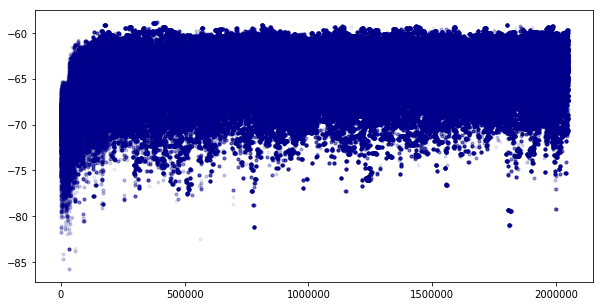

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
logchain = sampler.lnprobability.T.reshape((nwalkers*nsteps))
#logchain_start = logchain[:len(logchain)//2]
logchain_start = logchain
ax.scatter(np.linspace(0,len(logchain_start),len(logchain_start)),logchain_start,marker=".", color="darkblue", alpha="0.07");

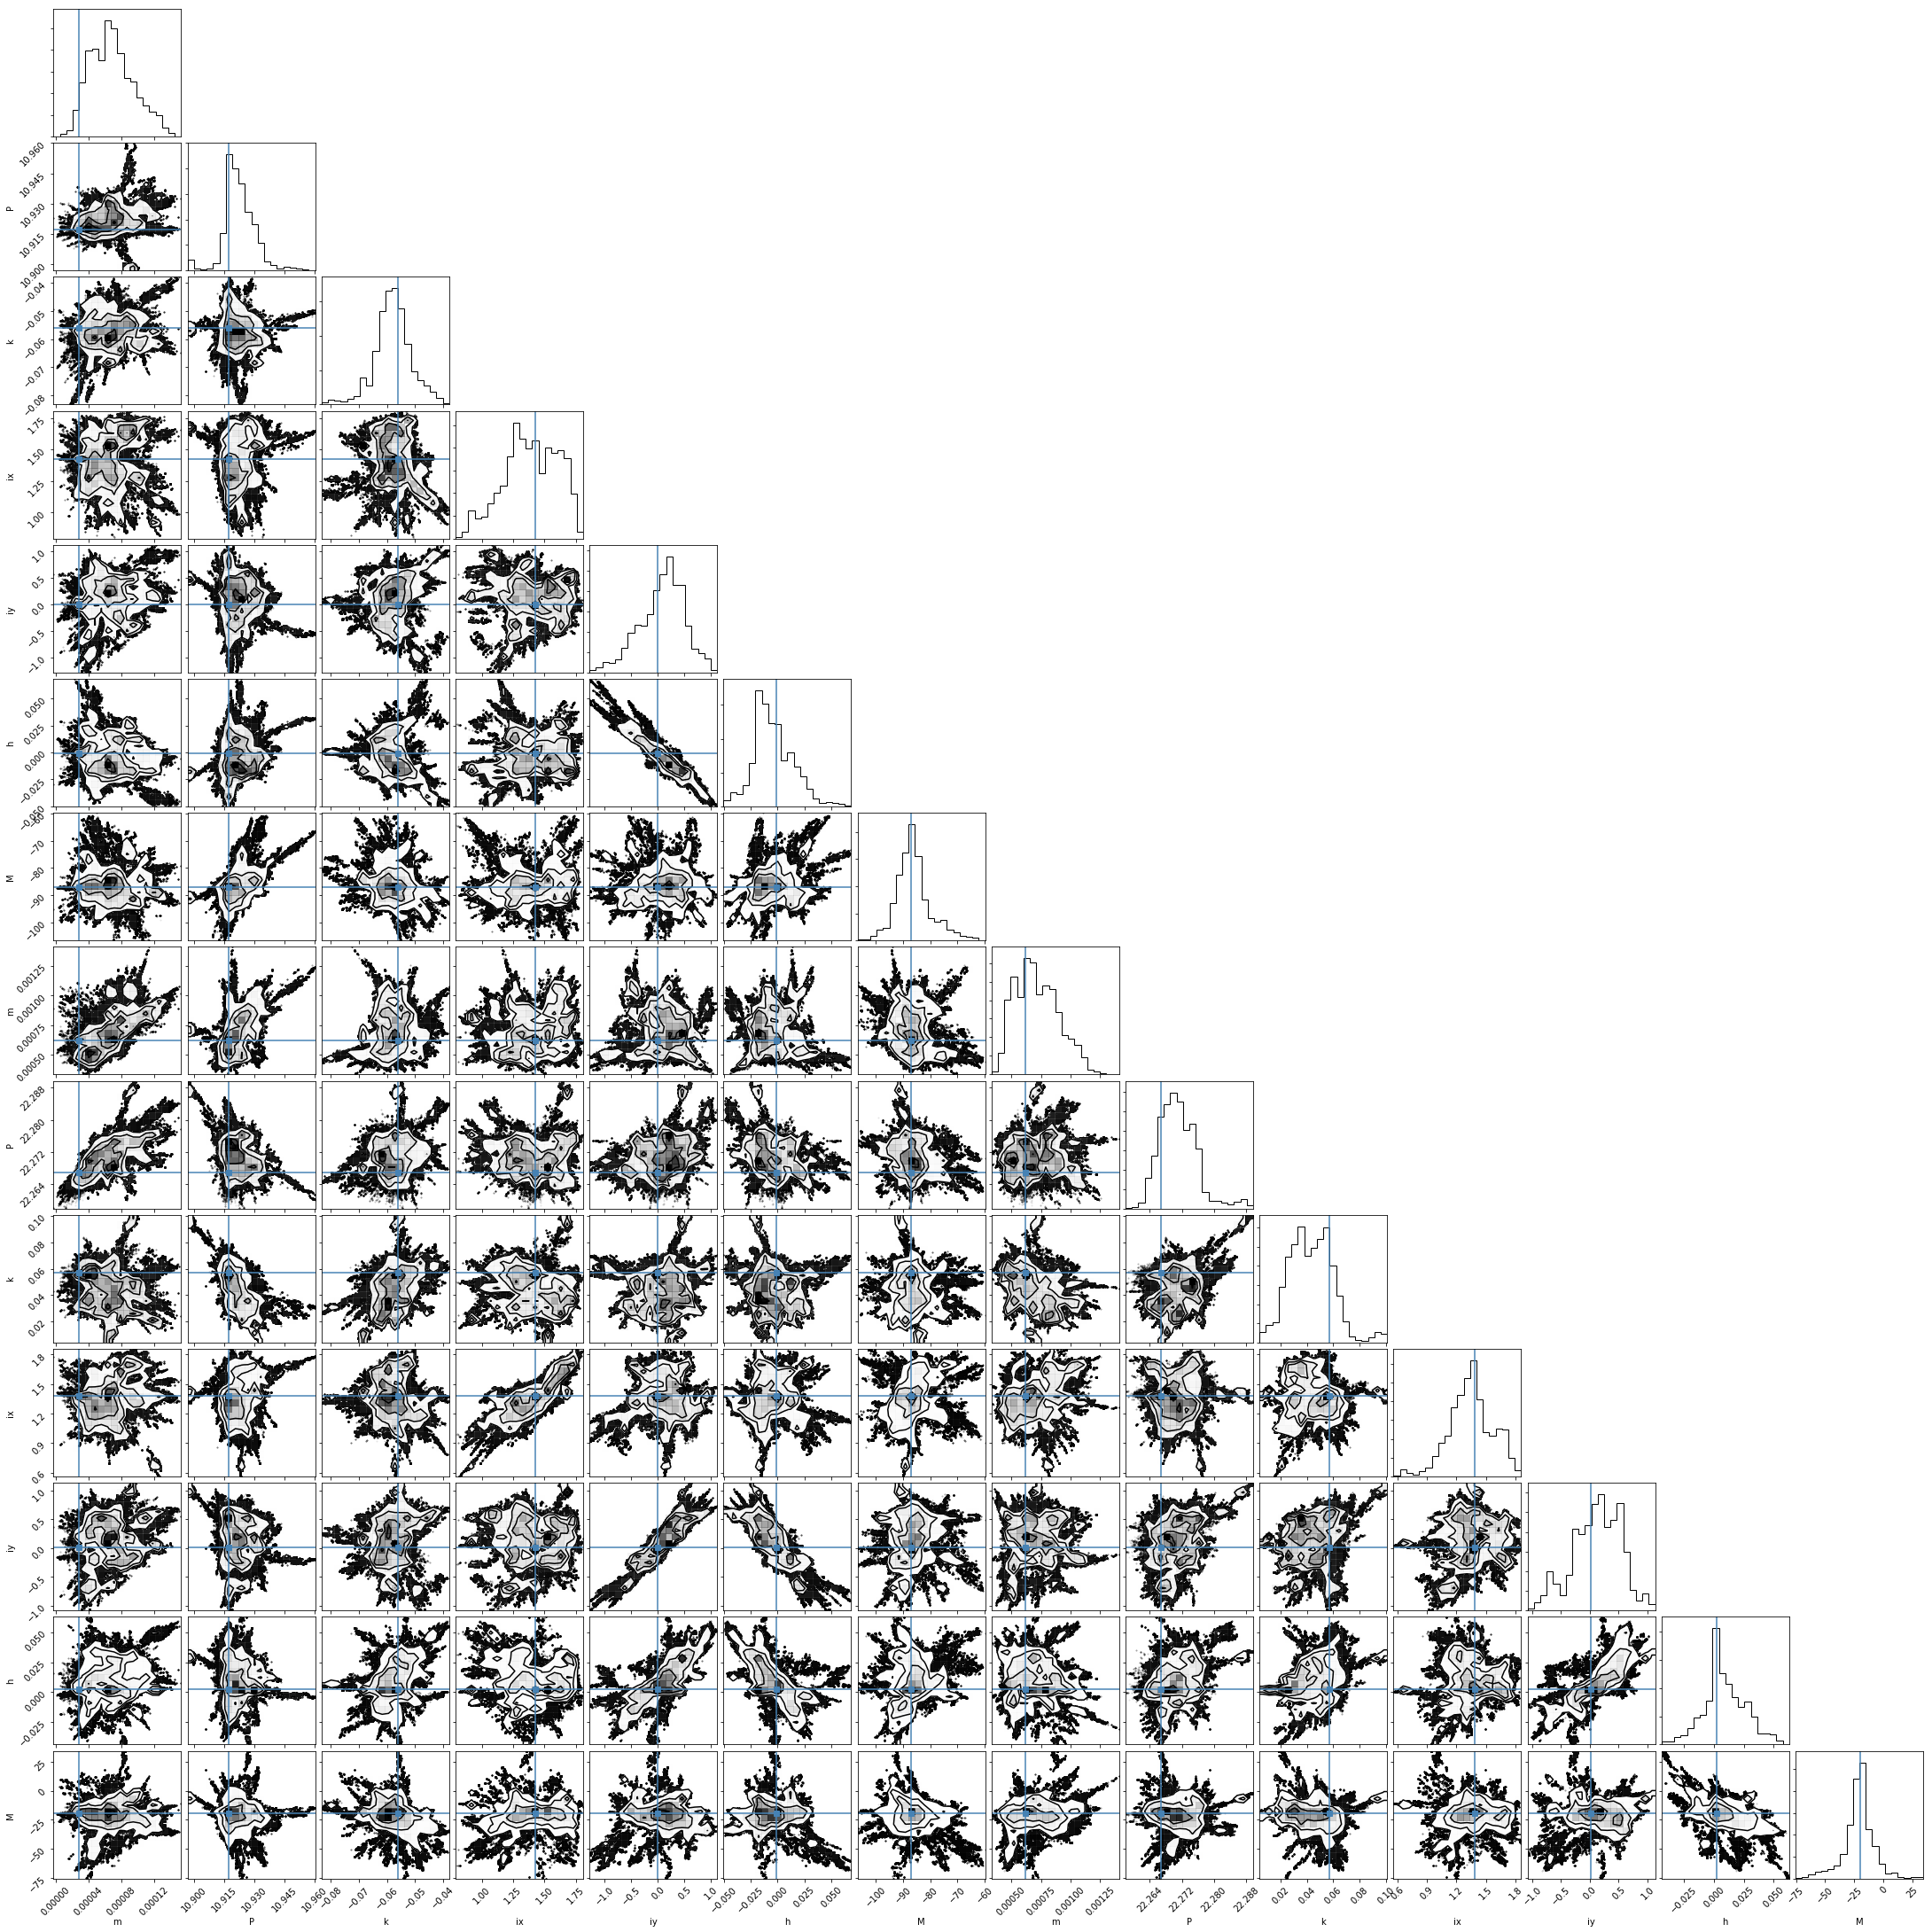

In [9]:
ncn= nc[len(nc)//2:]
lab = ['m','P', 'k', 'ix', 'iy', 'h', 'M']*2
corner.corner(ncn,truths=truth_pal, labels=lab);

# Below is old code kept for reference.

Plus TTV plots.

In [41]:
def lnprob_debug(param):
    #print "Params passed to lnprob: {p}".format(p=param)
    #with open("lnprobloggin.txt",'a') as f_handle:
        #np.savetxt(f_handle, param, delimiter=',', newline=';')
        #f_handle.write("\n    ^ Params when entering lnprob.\n")
        #f_handle.write("\n\n {a} \n\n".format(a=globalvar))
    integer_indices,times = get_times(param)
        #np.savetxt(f_handle, times, delimiter=',', newline=';')
        #f_handle.write("\n    ^ Times given from TTVFast. Lenght={le} \n".format(le=len(times)))
        #np.savetxt(f_handle, integer_indices, delimiter=',', newline=';')
        #f_handle.write("\n    ^ Integer_indices given from TTVFast.\n")
    p1nt = times[(integer_indices==0)]
    p2nt = times[(integer_indices==1)]
    l = 0.    
    i = 0 
    for t in p1nt:
        if i<len(p1tpe)-1:
            if abs(p1tpe[i+1]-t) < abs(p1tpe[i]-t):
                i += 1
        d = p1tpe[i] - t
        #if np.abs(d)<5.4:
        l += d**2/error**2
    i = 0 
    for t in p2nt:        
        if i<len(p2tpe)-1:
            if abs(p2tpe[i+1]-t) < abs(p2tpe[i]-t):
                i += 1
        d = p2tpe[i] - t
        #if np.abs(d)<5.4:
        l += d**2/error**2
    #np.savetxt(f_handle, [-l], delimiter=',', newline=';')
    #f_handle.write("\n    ^ -lnprob given from step.\n Time recorded: {t}.\n\n\n\n\n".format(t=datetime.now()))
    #f_handle.write("\n WalkerID: {a} \n\n\n\n\n".format(a=globalvar))
    #globalvar = globalvar + 1
    #if(os.stat('lnprobloggin.txt').st_size > 5000000):
    #    os.remove('lnprobloggin.txt')
    #if(l==0.0):
    #    return -np.inf
    #The following conditions could be added at the start for a very minor speedup.
    #np.abs(len(p1tpe)+len(p2tpe)+4 - len(p1nt) - len(p2nt))
    print p1nt
    print p2nt
    print p1tpe
    print p2tpe
    if(np.abs(len(p1tpe)+len(p2tpe)+4 - len(p1nt) - len(p2nt)) >0):
        return -np.inf
    #if(np.abs(len(p2tpe)+4 - len(p2nt)) >0):
    #    return -np.inf
    #print len(p1tpe)+len(p2tpe)+4 - len(p1nt) - len(p2nt)
    #if((len(p1tpe)+4 - len(p1nt)) == 0):
    #    return -l
    #else:
    #    return -np.inf
    return -l

In [7]:
params = list(pos0[2])
print lnprob(params)

[-159.92170877 -153.72508394 -148.99501174 -138.07216126 -131.45973033
 -127.14811362 -116.22900528 -109.19414003 -105.30740472  -94.39115405
  -86.92842185  -83.4721193   -72.55817164  -64.66262182  -61.64193721
  -50.72986618  -42.396751    -39.81659106  -28.9059065   -20.13081984
  -17.99545972   -7.08537498    2.13512697    3.82290235   14.73361003
   24.40097474   25.64102962   36.55419768   46.66651409   47.46288638
   58.38093942   68.93142498   69.29382975   80.21965191   91.14032195
   91.19527968  102.07692329  113.0092392   113.45758382  123.95921732
  134.90672202  135.71787382  145.87167236  156.83680505  157.97583346
  167.81690685  178.80041792  180.23138   ]
startp1
donep1
25.922980909
-36.2346584455


In [9]:
#params = list(pos0[2])
params[0] = 1.e-7
params[7] += 0.0007
print params
print lnprob(params)

[1e-07, 10.917340358278054, -0.05615161324033281, 1.4255361624156015, -3.1233966927610314e-08, -0.0009295806917200805, -87.0936527508579, 0.0020189591700041465, 22.266897776191076, 0.056653024039813746, 1.3842197142100867, 0.011166879854816519, 0.002083156868679981, -19.58485701947788]
[-159.92170816 -153.72486255 -148.97374239 -138.0398314  -131.45796991
 -127.10259387 -116.18565999 -109.19107574 -105.26087594  -94.36016967
  -86.92418008  -83.4501919   -72.56539122  -64.65728284  -61.67277695
  -50.80358684  -42.39038386  -39.930459    -29.0759584   -20.12348297
  -18.22303075   -7.38066779    2.14341976    3.45402615   14.28943945
   24.41032388   25.111852     35.94884383   46.76978506   46.67722828
   57.61990291   68.45460109   68.94413107   79.33036119   90.19566131
   91.21102989  101.10694594  112.01626479  113.4779228   122.96659501
  133.92487176  135.74480902  144.90991938  155.91216936  158.01168926
  166.92105407  177.95470851  180.27856539]
startp1
donep1
2771356.98719
-

In [9]:
def ttv_from_times(t1_times):
    import scipy.stats as stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(t1_times)),t1_times)
    print "Results from linear regression are... Slope:{s}, Intercept:{i}, std_err:{std}, r_value:{r}, p_value:{p}".format(s=slope,i=intercept,std=std_err,r=r_value,p=p_value)
    diff = (np.arange(len(t1_times))*slope + intercept) - np.asarray(t1_times)
    return t1_times, diff

In [10]:
params = list(pos0[2])
params[0] -= 0.00005
params[7] += 0.0007
A, B = get_times(params)
p1tpe = B[(A==0)]
p2tpe = B[(A==1)]

In [11]:
t1, ttv1 = ttv_from_times(p1tpe)
t2, ttv2 = ttv_from_times(p2tpe)

Results from linear regression are... Slope:10.9028179736, Intercept:-159.846763554, std_err:0.00201242338276, r_value:0.999999488963, p_value:2.004431204e-91
Results from linear regression are... Slope:22.2675433453, Intercept:-153.725312601, std_err:0.000160531057968, r_value:0.999999999636, p_value:2.26171692666e-65


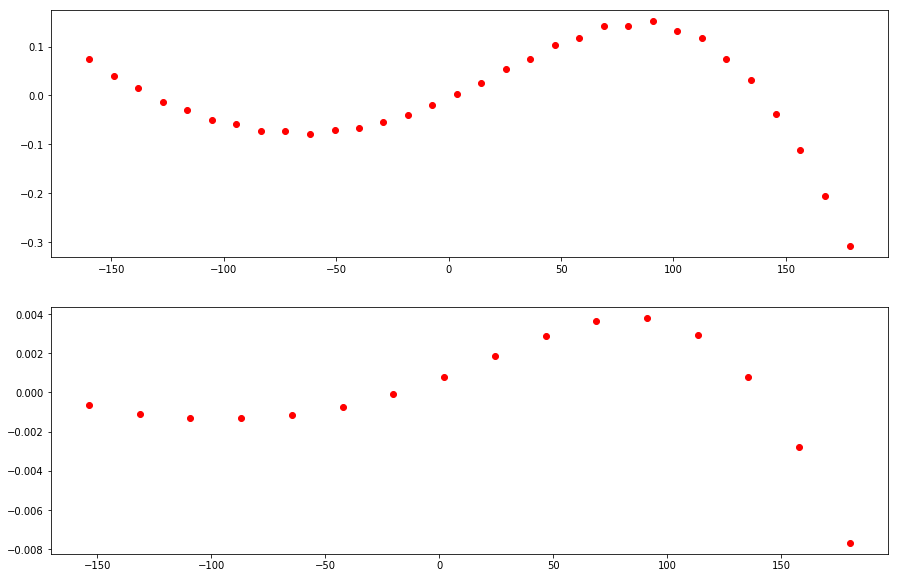

In [12]:
fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].plot(t1,ttv1, 'ro')
ax[1].plot(t2,ttv2, 'ro')

In [90]:
def ttv_from_times(t1_times):
    import scipy.stats as stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(t1_times)),t1_times)
    print "Results from linear regression are... Slope:{s}, Intercept:{i}, std_err:{std}, r_value:{r}, p_value:{p}".format(s=slope,i=intercept,std=std_err,r=r_value,p=p_value)
    diff = (np.arange(len(t1_times))*slope + intercept) - np.asarray(t1_times)
    return t1_times, diff

In [91]:
t1, ttv1 = ttv_from_times(p1tpe)
t2, ttv2 = ttv_from_times(p2tpe)

Results from linear regression are... Slope:10.954323912, Intercept:-189.430882196, std_err:0.000765013178024, r_value:0.999999697616, p_value:0.0
Results from linear regression are... Slope:22.2599068404, Intercept:-171.432359151, std_err:0.00017410743167, r_value:0.999999998195, p_value:9.10232279416e-251


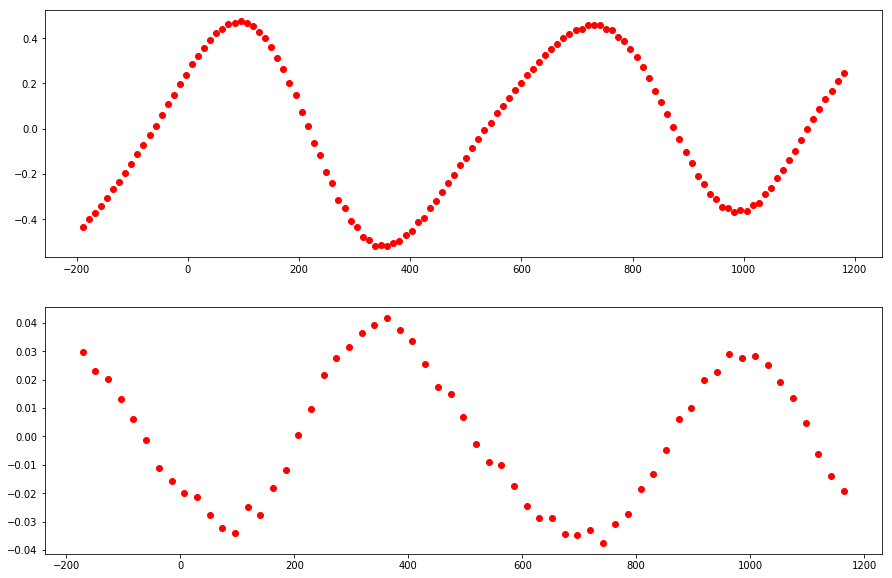

In [92]:
fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].plot(t1,ttv1, 'ro')
ax[1].plot(t2,ttv2, 'ro')

In [102]:
t1, ttv1 = ttv_from_times(p1tpe)
t2, ttv2 = ttv_from_times(p2tpe)

Results from linear regression are... Slope:10.9178099415, Intercept:-144.002052791, std_err:0.00100532730704, r_value:0.999999885534, p_value:3.45374290335e-91
Results from linear regression are... Slope:22.2652778973, Intercept:-126.459071778, std_err:0.000304136908245, r_value:0.999999998974, p_value:3.88058937485e-49


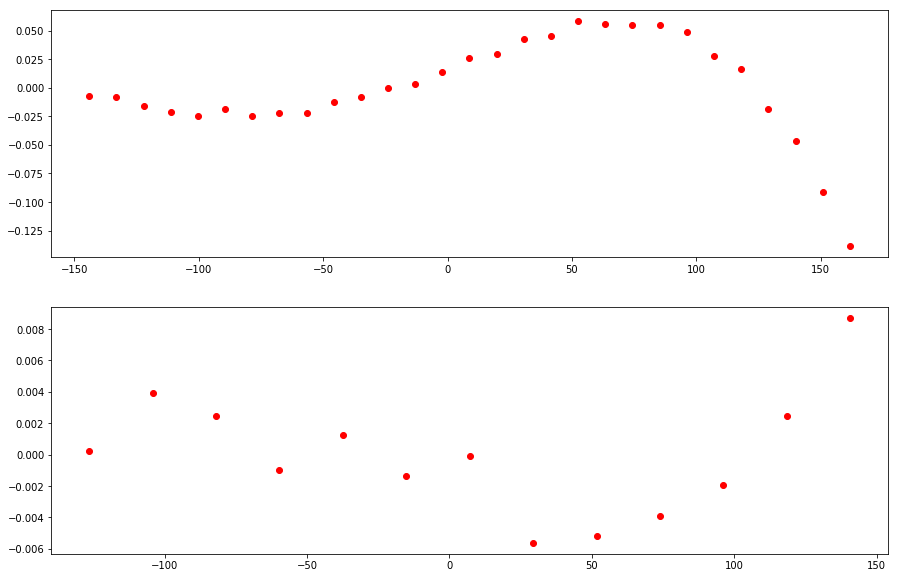

In [103]:
fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].plot(t1,ttv1, 'ro')
ax[1].plot(t2,ttv2, 'ro')

In [110]:
t1, ttv1 = ttv_from_times(p1tpe)
t2, ttv2 = ttv_from_times(p2tpe)

Results from linear regression are... Slope:10.9590630766, Intercept:-189.534066226, std_err:0.00303882732469, r_value:0.999998039332, p_value:1.50863961766e-139
Results from linear regression are... Slope:22.2587874598, Intercept:-171.420859197, std_err:0.00067015864225, r_value:0.999999989576, p_value:7.68737043241e-90


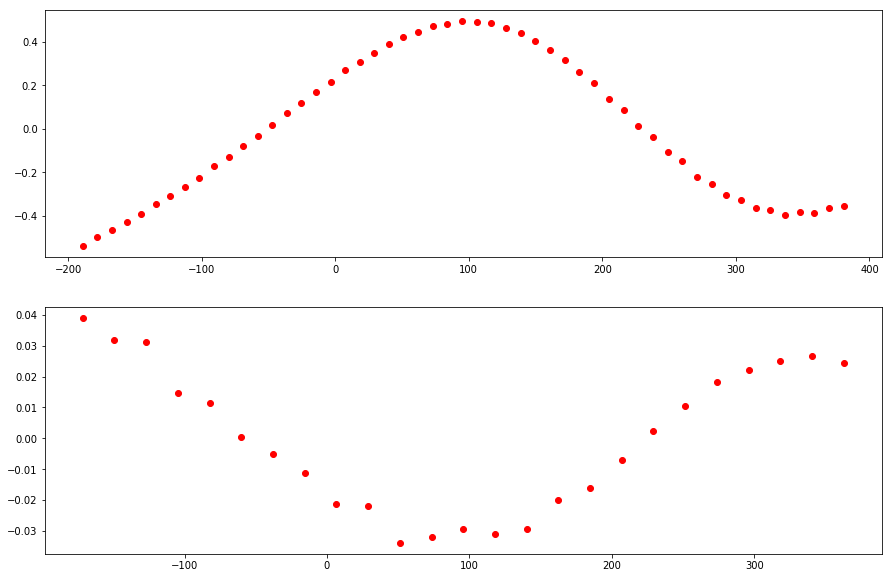

In [111]:
fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].plot(t1,ttv1, 'ro')
ax[1].plot(t2,ttv2, 'ro')